In [1]:
%load_ext autoreload
%autoreload 2

In [27]:
from datetime import datetime
from types import SimpleNamespace
import os
from glob import glob
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import wandb
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import xarray
import pandas as pd
from dataset.dataset import ImageDataset, SingleImageDataset, pickle_read, SeviriDataset
from dataset.normalization import MinMax, ZeroMinMax
from dataset.station_dataset import GroundstationDataset, GroundstationDataset2
from lightning.pytorch import Trainer, LightningDataModule
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from models.ConvResNet_Jiang import ConvResNet, ConvResNet_dropout, ConvResNet_batchnormMLP
from models.LightningModule import LitEstimator, LitEstimatorPoint
from torch.utils.data import DataLoader, Dataset, Subset
from tqdm import tqdm
from utils.plotting import prediction_error_plot, plot_station_locations
from cartopy.mpl.gridliner import (
    LongitudeFormatter,
    LatitudeFormatter,
    LongitudeLocator,
    LatitudeLocator,
)
plt.rcParams['text.usetex'] = False

In [32]:
## Set Up Model

ckpt_fn = './SIS_point_estimation/wv1ykh5d/checkpoints/epoch=8-step=8946.ckpt'

inference_fn = ckpt_fn.split('checkpoints')[0] + 'inference/'
if not os.path.exists(inference_fn):
    os.mkdir(inference_fn)

config = {
    "batch_size": 1024,
    "patch_size": {
        "x": 15,
        "y": 15,
        "stride_x": 1,
        "stride_y": 1,
    },
    "x_vars": [
        "channel_1",
        "channel_2",
        "channel_3",
        "channel_4",
        "channel_5",
        "channel_6",
        "channel_7",
        "channel_8",
        "channel_9",
        "channel_10",
        "channel_11",
        "DEM",
    ],
    "y_vars": ["SIS",],
    "x_features": ["dayofyear", "lat", "lon", 'SZA', "AZI",],
    "transform": ZeroMinMax(),
    "target_transform": ZeroMinMax(),
    'max_epochs': 50,
    # Compute related
    'num_workers': 0,
    'ACCELERATOR': "gpu",
    'DEVICES': -1,
    'NUM_NODES': 32,
    'STRATEGY': "ddp",
    'PRECISION': "32",
    'EarlyStopping': {'patience':2},
    'ModelCheckpoint':{'every_n_epochs':1, 'save_top_k':1}
}
config = SimpleNamespace(**config)

In [4]:
ch = torch.load(ckpt_fn, map_location=torch.device('cuda'))
model = ConvResNet_batchnormMLP(
    num_attr=len(config.x_features),
    input_channels=len(config.x_vars),
    output_channels=len(config.y_vars),
)

In [5]:
estimator = LitEstimatorPoint(learning_rate=0.0001, model=model, config=config)
estimator.load_state_dict(ch['state_dict'])

<All keys matched successfully>

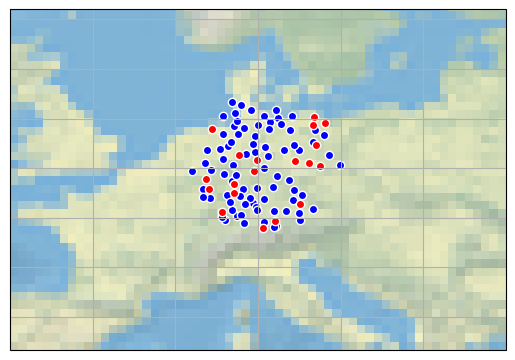

In [6]:
zarr_fns = glob('../../ZARR/DWD/DWD_SOLAR_*.zarr')
station_names = [int(os.path.basename(fn).split('SOLAR_')[-1].split('.')[0]) for fn in zarr_fns]
index = xarray.open_dataset('/scratch/snx3000/kschuurm/DATA/DWD/netcdf/DWD_SOLAR_index.nc')
index = index.sel(station_id=station_names)

# train_id, valid_id = torch.utils.data.random_split(station_names, [.8, .2])
# print(list(train_id), list(valid_id))

train_id = [15000, 2638, 662, 342, 691, 4104, 1684, 5426, 1766, 3167, 596, 880, 1346, 4271, 1550, 3196, 5792, 2485, 856, 1468, 3287, 4336, 701, 3126, 891, 1078, 4393, 963, 5705, 5546, 7368, 4887, 164, 704, 2261, 656, 2559, 6197, 3513, 3032, 7351, 430, 1443, 2907, 5856, 5404, 6163, 2483, 3268, 2601, 15444, 13674, 7374, 5480, 7367, 4745, 2014, 4625, 5100, 3761, 460, 7369, 3086, 3366, 282, 591, 1639, 232, 4177, 7370, 2667, 4928, 2712, 4466, 5397, 5516, 1975, 1503, 2115, 1605]
valid_id = [1757, 5109, 953, 3028, 2290, 5906, 2171, 427, 2932, 2812, 5839, 1691, 3811, 1420, 5142, 4911, 3660, 3730, 1048]

index_train = index.sel(station_id=train_id); index_valid = index.sel(station_id=valid_id)

a = index_train.plot.scatter(x='lon', y='lat', c='b', subplot_kws=dict(projection=ccrs.PlateCarree()), transform=ccrs.PlateCarree())
index_valid.plot.scatter(x='lon', y='lat', c='r', subplot_kws=dict(projection=ccrs.PlateCarree()), transform=ccrs.PlateCarree())
a.axes.gridlines()
a.axes.stock_img()
a.axes.set_extent([-5, 25, 40, 60])
plt.show()

In [7]:
valid_datasets = [GroundstationDataset2(f'../../ZARR/DWD/DWD_SOLAR_{str(x).zfill(5)}.zarr', config.y_vars, config.x_vars, config.x_features, config.patch_size['x'], config.transform, config.target_transform, subset_year=2016)
            for x in tqdm(valid_id)]
valid_dataset = torch.utils.data.ConcatDataset(valid_datasets)


100%|██████████| 19/19 [02:06<00:00,  6.67s/it]


In [8]:
train_datasets = [GroundstationDataset2(f'../../ZARR/DWD/DWD_SOLAR_{str(x).zfill(5)}.zarr', config.y_vars, config.x_vars, config.x_features, config.patch_size['x'], config.transform, config.target_transform)
            for x in tqdm(train_id)]
train_dataset = torch.utils.data.ConcatDataset(train_datasets)


100%|██████████| 80/80 [10:11<00:00,  7.65s/it]


In [26]:

class DataModule(LightningDataModule):

  def __init__(self, train_dataset, val_dataset,  batch_size = 2):

    super(DataModule, self).__init__()
    self.train_dataset = train_dataset
    self.val_dataset = val_dataset
    self.batch_size = batch_size
  def train_dataloader(self):
    return DataLoader(self.train_dataset, batch_size = self.batch_size, shuffle = True)
  
  def val_dataloader(self):
    return DataLoader(self.val_dataset, batch_size = self.batch_size, shuffle = False)

dm = DataModule(train_dataset, valid_dataset, config.batch_size)


In [27]:

wandb_logger = WandbLogger(project="SIS_point_estimation_groundstation")

mc_sarah = ModelCheckpoint(
        monitor='val_loss', 
        every_n_epochs=config.ModelCheckpoint['every_n_epochs'], 
        save_top_k = config.ModelCheckpoint['save_top_k'],
        filename='{epoch}-{val_loss:.5f}'
    ) 
early_stopping = EarlyStopping(monitor='val_loss', patience=config.EarlyStopping['patience'])

trainer = Trainer(
    logger=wandb_logger,
    max_epochs=12,
    accelerator='gpu',
    precision=config.PRECISION,
    callbacks=[early_stopping, mc_sarah],
    log_every_n_steps=500,
    num_sanity_val_steps=0,
    max_time="00:6:00:00",
    limit_train_batches=.2,
    reload_dataloaders_every_n_epochs=1, # ensures a random 20% of the train dataset is picked
)


/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scratch/snx3000/kschuurm/lightning-env/lib/python3. ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(estimator, dm)

wandb.finish()

In [ ]:
# Bias correction

In [58]:
from torchmetrics import MeanAbsoluteError, MeanMetric
from train import get_dataloaders

wandb_logger = WandbLogger(project="SIS_point_estimation_groundstation")

mc_sarah = ModelCheckpoint(
        monitor='val_loss', 
        every_n_epochs=config.ModelCheckpoint['every_n_epochs'], 
        save_top_k = config.ModelCheckpoint['save_top_k'],
        filename='{epoch}-{val_loss:.5f}'
    ) 
early_stopping = EarlyStopping(monitor='val_loss', patience=config.EarlyStopping['patience'])

trainer = Trainer(
    logger=wandb_logger,
    max_epochs=3,
    accelerator='gpu',
    precision=config.PRECISION,
    callbacks=[early_stopping, mc_sarah],
    log_every_n_steps=500,
    limit_train_batches=.1,
    # num_sanity_val_steps=0,
    max_time="00:3:00:00",
)

ch = torch.load('/scratch/snx3000/kschuurm/irradiance_estimation/train/SIS_point_estimation_groundstation/1otg6d0w/checkpoints/epoch=3-val_loss=0.01542.ckpt', map_location=torch.device('cuda'))
estimator_bias = LitEstimatorPoint(learning_rate=0.0001, model=model.float(), config=config, metric=MeanAbsoluteError())
estimator_bias.load_state_dict(ch['state_dict'])
estimator_bias.float()

val_dataloader = DataLoader(valid_dataset, batch_size=config.batch_size, shuffle=False)
# train_dataloader, _ = get_dataloaders(config)

/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scratch/snx3000/kschuurm/lightning-env/lib/python3. ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'metric' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric'])`.


In [60]:
timeindex = pd.DatetimeIndex(pickle_read('/scratch/snx3000/kschuurm/ZARR/timeindices.pkl'))
traintimeindex = timeindex[(timeindex.year <= 2021)]

rng = np.random.default_rng(seed=420)
train_dataset = SeviriDataset(
    x_vars=config.x_vars,
    y_vars=config.y_vars,
    x_features=config.x_features,
    patch_size=config.patch_size,
    transform=config.transform,
    target_transform=config.target_transform,
    patches_per_image=1024,
    timeindices=traintimeindex,
    rng=rng,
)

train_subset = Subset(train_dataset, [0.01])

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=None, num_workers=0)

In [ ]:
trainer.fit(
    estimator_bias, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader
)

/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scratch/snx3000/kschuurm/lightning-env/lib/python3. ...
/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/lightning/pytorch/loggers/wandb.py:391: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                    | Params
----------------------------------------------------------
0 | model         | ConvResNet_batchnormMLP | 6.4 M 
1 | metric        | MeanAbsoluteError       | 0     
2 | other_metrics | MetricCollection        | 0     
---------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]